# Assignment #4: Linear Models and Decision Trees
## Foundations of Machine Learning
## Do Q1 and one other question.
### Advice: Reuse your code and code from lectures, package routine tasks into functions, make plans about how you'll carry out the analysis before jumping into writing code, and work as efficiently as possible

**Q1.** This question is a case study for linear models and decision trees. The data are about car prices. In particular, they include:

  - `Price`, `Color`, `Seating_Capacity`
  - `Body_Type`: crossover, hatchback, muv, sedan, suv
  - `Make`, `Make_Year`: The brand of car and year produced
  - `Mileage_Run`: The number of miles on the odometer
  - `Fuel_Type`: Diesel or gasoline/petrol
  - `Transmission`, `Transmission_Type`:  speeds and automatic/manual

  1. Load `cars_hw.csv`. These data were really dirty, and I've already cleaned them a significant amount in terms of missing values and other issues, but some issues remain (e.g. outliers, badly scaled variables that require a log or arcsinh transformation). Clean the data however you think is most appropriate.
  2. Summarize the `Price` variable and create a kernel density plot. Use `.groupby()` and `.describe()` to summarize prices by brand (`Make`). Make a grouped kernel density plot by `Make`. Which car brands are the most expensive? What do prices look like in general?
  3. Split the data into an 80% training set and a 20% testing set.
  4. Let's focus on linear models. Make a model where you regress price on the numeric variables alone; what is the $R^2$ and `RMSE` on the test set? Make a second model where, for the categorical variables, make a model comprised of one-hot encoded regressors/features alone, and regress price on those variables; what is the $R^2$ and `RMSE` on the test set? Which model performs better on the test set? Make a third model that combines all the regressors from the previous two; what is the $R^2$ and `RMSE` on the test set? Does the joint model perform better or worse, and by home much?
  5. Use the `PolynomialFeatures` function from `sklearn` to expand the set of numerical variables you're using, along with the categorical variables. As you increase the degree of the expansion, how do the $R^2$ and `RMSE` change? At what point does $R^2$ go negative on the test set? For your best model with expanded features, what is the $R^2$ and `RMSE`? How does it compare to your best model from part 3?
  6. For your best model so far, determine the predicted values for the test data and plot them against the true values. Do the predicted values and true values roughly line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero? Evaluate the strengths and weaknesses of your model.
  7. Now, let's use a regression tree. Construct an appropriate matrix of regressors/features, and fit a tree to the data. Vary the maximum depth of the decision tree using the `max_depth` option (i.e. `tree.DecisionTreeRegressor(max_depth=D)`), and compute the $R^2$ and `RMSE` on the test set of a variety of depths. What depth tree gives the best results?
  8. For your best tree, determine the predicted values for the test data, and plot them against the true values. Do the predicted values and true values line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero?
  12. Which model --- linear model or classification and regression tree --- has better performance on the test set?

  *It looks like the linear model did slightly better than the regression tree on the test set - R-squared was higher and RMSE was lower on the former than on the latter.*

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import warnings
import math
warnings.filterwarnings('ignore')
########################## 1.1 ########################
url1 = 'https://raw.githubusercontent.com/3agleman/assignment4/main/data/cars_hw.csv'
cars0 = pd.read_csv(url1)
cars = cars0
cars = cars.loc[cars['Price'] != 2941000] #remove an outlier for price
cars['Price_scaled'] = np.arcsinh(cars['Price'])
cars['prev_owners'] = pd.factorize(cars['No_of_Owners'])[0] # make no owners a numeric variable, 0 = 1, 1 = 2, and so on
# Otherwise looks good to me, all variables are either categorical or (mostly) normally distributed
cars['Age'] = 2023 - cars['Make_Year'] # Added this one in so we can have an extra numeric variable, as a treat
cars['Age_scaled'] = np.arcsinh(cars['Age'])

# One-hot encoding for question 4 (so I don't have to split test/train again)
from sklearn.preprocessing import LabelBinarizer
one_hot_encoder = LabelBinarizer()

categorials = ['Color','Seating_Capacity','Body_Type','Make','Fuel_Type','Transmission']

def OHE(eks):
  oh = one_hot_encoder.fit_transform(cars[eks])
  names = one_hot_encoder.classes_
  zdf = pd.DataFrame(data = oh, columns = names)
  return zdf

for cat in categorials:
  k = OHE(cat)
  cars = cars.join(k, how = 'left')
cars.columns = cars.columns.astype(str)
########################### 1.2 #######################
brands = cars.groupby('Make')
#print(brands['Price'].describe())
sns.kdeplot(data = cars, hue = 'Make', x = 'Price')
plt.pyplot.close()
# It looks like MG Motors and Kia are two of the most expensive car brands, given the differences between their density plots and those of the rest of the brands.

############################# 1.3 #######################
cars['Mileage_Run_sq'] = cars['Mileage_Run']**2 #for later
cars['Age_scaled_sq'] = cars['Age_scaled']**2

from sklearn.model_selection import train_test_split
cars_train, cars_test = train_test_split(cars, test_size = .2, random_state = 100)

################### 1.4 #######################
from sklearn.linear_model import LinearRegression

vars = ['Mileage_Run','Mileage_Run_sq','Age_scaled','Age_scaled_sq']
X = cars_train.loc[:,vars]
y = cars_train['Price_scaled']
reg = LinearRegression().fit(X, y)
print(reg.score(X,y)) # R-squared: 0.4282
X_test = cars_test.loc[:,vars]
X_predict = reg.predict(X_test)
Y_test = cars_test['Price_scaled']
from sklearn.metrics import mean_squared_error as mse
print(math.sqrt(mse(Y_test,X_predict))) # RMSE: 0.3627

# Now for the categoricals (?)
cars_2_train = cars_train.drop(['Make','Make_Year','Color','Body_Type','Mileage_Run','No_of_Owners','Seating_Capacity','Fuel_Type','Transmission','Transmission_Type','Price','prev_owners','Age','Age_scaled','Mileage_Run_sq','Age_scaled_sq'],
                   axis = 1)
cars_2_train = cars_2_train.dropna()
cars_2_test = cars_test.drop(['Make','Make_Year','Color','Body_Type','Mileage_Run','No_of_Owners','Seating_Capacity','Fuel_Type','Transmission','Transmission_Type','Price','prev_owners','Age','Age_scaled','Mileage_Run_sq','Age_scaled_sq'],
                   axis = 1)
cars_2_test = cars_2_test.dropna()
vars_2 = ['beige',         'black',
                'blue',        'bronze',         'brown',        'golden',
               'green',          'grey',        'maroon',        'orange',
              'purple',           'red',        'silver',         'white',
              'yellow',               '4',               '5',               '6',
                     '7',               '8',     'crossover',     'hatchback',
                 'muv',         'sedan',           'suv',     'Chevrolet',
              'Datsun',          'Ford',         'Honda',       'Hyundai',
                'Jeep',           'Kia',     'MG Motors',      'Mahindra',
       'Maruti Suzuki',        'Nissan',       'Renault',         'Skoda',
                'Tata',        'Toyota',    'Volkswagen',        'diesel',
              'petrol',    'petrol+cng',       '4-Speed',       '5-Speed',
             '6-Speed',       '7-Speed',           'CVT']

X_2 = cars_2_train.loc[:,vars_2]
y_2 = cars_2_train['Price_scaled']
reg_2 = LinearRegression().fit(X_2, y_2)
print(reg_2.score(X_2,y_2)) # R-squared: 0.1783
X_test_2 = cars_2_test.loc[:,vars_2]
X_predict_2 = reg_2.predict(X_test_2)
Y_test_2 = cars_2_test['Price_scaled']
from sklearn.metrics import mean_squared_error as mse
print(math.sqrt(mse(Y_test_2,X_predict_2))) # RMSE: 0.4500
# It would appear that the first model is still better than the second model, because its R-squared is higher and its RMSE is lower.

# Now to combine them...
vars_3 = ['beige',         'black',
                'blue',        'bronze',         'brown',        'golden',
               'green',          'grey',        'maroon',        'orange',
              'purple',           'red',        'silver',         'white',
              'yellow',               '4',               '5',               '6',
                     '7',               '8',     'crossover',     'hatchback',
                 'muv',         'sedan',           'suv',     'Chevrolet',
              'Datsun',          'Ford',         'Honda',       'Hyundai',
                'Jeep',           'Kia',     'MG Motors',      'Mahindra',
       'Maruti Suzuki',        'Nissan',       'Renault',         'Skoda',
                'Tata',        'Toyota',    'Volkswagen',        'diesel',
              'petrol',    'petrol+cng',       '4-Speed',       '5-Speed',
             '6-Speed',       '7-Speed',           'CVT','Mileage_Run','Mileage_Run_sq','Age_scaled','Age_scaled_sq']
cars_3_train = cars_train.dropna()
cars_3_test = cars_test.dropna()

X_3 = cars_3_train.loc[:,vars_3]
y_3 = cars_3_train['Price_scaled']
reg_3 = LinearRegression().fit(X_3, y_3)
print(reg_3.score(X_3,y_3)) # R-squared: 0.5324
X_3_test = cars_3_test.loc[:,vars_3]
X_3_predict = reg_3.predict(X_3_test)
Y_3_test = cars_3_test['Price_scaled']
from sklearn.metrics import mean_squared_error as mse
print(math.sqrt(mse(Y_3_test,X_3_predict))) # RMSE: 0.3319
# The joint model looks like it's better than both of the above models: higher R-squared, lower RMSE.

##################### 1.5 #####################
#Use the PolynomialFeatures function from sklearn to expand the set of numerical variables you're using,
#along with the categorical variables. As you increase the degree of the expansion, how do the R2 and RMSE change?
#At what point does R2 go negative on the test set? For your best model with expanded features, what is the R2 and RMSE?
#How does it compare to your best model from part 3?
from sklearn.preprocessing import PolynomialFeatures
numerics = cars.loc[:,['Mileage_Run','Mileage_Run_sq','Age_scaled','Age_scaled_sq']]

expander = PolynomialFeatures(degree=2,include_bias=False)
Z = expander.fit_transform(numerics)
names = expander.get_feature_names_out()
numerics_expanded = pd.DataFrame(data=Z, columns = names)

cars_expanded = cars.merge(numerics_expanded, how = 'left')

from sklearn.model_selection import train_test_split
cars_train_expanded, cars_test_expanded = train_test_split(cars_expanded, test_size = .2, random_state = 100)
cars_train_expanded = cars_train_expanded.dropna()
cars_test_expanded = cars_test_expanded.dropna()

vars_q5 = vars_3 + numerics_expanded.columns.to_list()
vars_q5 = np.array(vars_q5)
vars_q5 = np.unique(vars_q5)
vars_q5 = vars_q5.tolist()
# now to actually do the model...
X5 = cars_train_expanded.loc[:,vars_q5]
y5 = cars_train_expanded['Price_scaled']
reg5 = LinearRegression().fit(X5, y5)
print(reg5.score(X5,y5)) # R-squared: 0.4771 (2 degrees), 0.0598 (5 degrees), 0.0196 (9 degrees), -0.0185 (10 degrees)
X_5_test = cars_test_expanded.loc[:,vars_q5]
X_5_predict = reg5.predict(X_5_test)
Y_5_test = cars_test_expanded['Price_scaled']
from sklearn.metrics import mean_squared_error as mse
print(math.sqrt(mse(Y_5_test,X_5_predict))) # RMSE: 0.3323 (2 degrees), 0.4721 (5 degrees), 0.4863 (9 degrees), 0.4891 (10 degrees)
# roughly the same as the combined dataset at 2 degrees. R2 gets smaller and RMSE gets bigger as degrees change, R2 goes negative between 9 and 10 degrees.
# Seems like the best model is the model with 2 degrees, which is still slightly worse than the model in 1.4(3). Overfitting, perhaps?

############### 1.6 ####################
# For your best model so far, determine the predicted values for the test data and plot them against the true values.
# Do the predicted values and true values roughly line up along the diagonal, or not?
# Compute the residuals/errors for the test data and create a kernel density plot.
# Do the residuals look roughly bell-shaped around zero? Evaluate the strengths and weaknesses of your model.
import matplotlib.pyplot as plt2

print('#######1.6########')
plt2.scatter(Y_3_test,X_3_predict,label='Data')
plt2.xlabel("X")
plt2.ylabel("Y")
plt2.legend(loc='lower right')
plt2.title('Linear Regression')
plt2.show()
# Looks like they do roughly line up along the diagonal.

residuals = (Y_3_test - X_3_predict)
residuals.plot.kde()
# Looks like it is indeed bell-shaped around zero.

In [ ]:
############# 1.7 ################
# Sadly I didn't get my feedback for HW3 back until just now, finally realized I don't have to put everything in one big code chunk :')

# Now, let's use a regression tree. Construct an appropriate matrix of regressors/features, and fit a tree to the data.
# Vary the maximum depth of the decision tree using the max_depth option (i.e. tree.DecisionTreeRegressor(max_depth=D)),
# and compute the R2 and RMSE on the test set of a variety of depths. What depth tree gives the best results?

from sklearn import tree
X = cars_2_train.loc[:,vars_2]
y = cars_2_train['Price_scaled']
X_test = cars_2_test.loc[:,vars_2]
y_test = cars_2_test['Price_scaled']

cart = tree.DecisionTreeRegressor(max_depth = 58)
cart = cart.fit(X, y)
#tree.plot_tree(cart,filled=True)
print(cart.score(X,y)) # R-squared of 0.4630 (58)
X_predict = cart.predict(X_test)
from sklearn.metrics import mean_squared_error as mse
print(math.sqrt(mse(y_test,X_predict))) # RMSE of 0.4994 (58)

def depthRsquared(x):
  carte = tree.DecisionTreeRegressor(max_depth = x)
  carte = carte.fit(X, y)
  return carte.score(X, y)

def depthRMSE(x):
  carte = tree.DecisionTreeRegressor(max_depth = x)
  carte = carte.fit(X, y)
  X_predict = carte.predict(X_test)
  return math.sqrt(mse(y_test,X_predict))

rsquareds = []
rmses = []

maxx = 1
while (maxx < 100):
  rsquareds.append(depthRsquared(maxx))
  rmses.append(depthRMSE(maxx))
  maxx = maxx + 1

rsquaredSer = pd.Series(rsquareds).sort_values(ascending=False)
RMSESer = pd.Series(rmses).sort_values(ascending=False)
print(rsquaredSer)
print(RMSESer)
# Looks like depth = 58 is the best for both R-squared (2nd best) and RMSE (1st best)

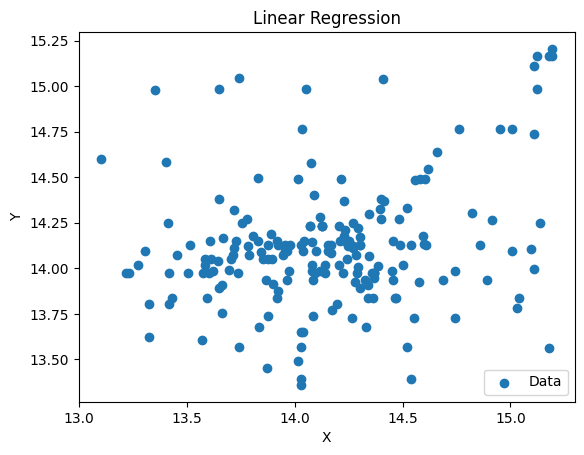

<Axes: ylabel='Density'>

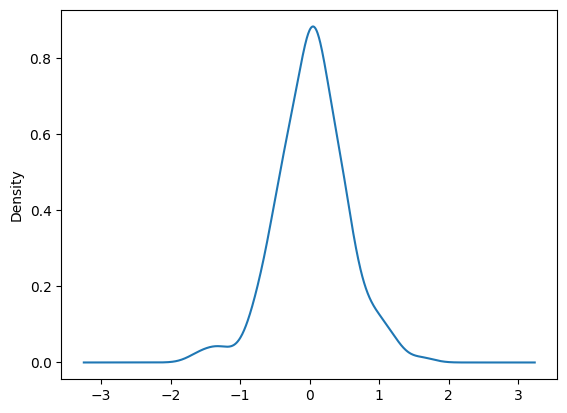

In [82]:
################# 1.8 ###############
# For your best tree, determine the predicted values for the test data, and plot them against the true values.
# Do the predicted values and true values line up along the diagonal, or not?
# Compute the residuals/errors for the test data and create a kernel density plot.
# Do the residuals look roughly bell-shaped around zero?

plt2.scatter(y_test,X_predict,label='Data')
plt2.xlabel("X")
plt2.ylabel("Y")
plt2.legend(loc='lower right')
plt2.title('Linear Regression')
plt2.show()
# Looks like they *might* be aligned, lot of random noise though.

residuals = (y_test - X_predict)
residuals.plot.kde()
# It would seem that it is indeed bell-shaped around zero (maybe a little too pointy?)

###################1.9######################
# See above.

**Q2.** The is a question about regression using decision trees and linear models. The data include wages at data science-y jobs, including

  - `Rating`: Company worker happiness score
  - `Size`: Number of employees
  - `Sector`: Part of the economy
  - `avg_salary`: Average wage
  - `job_state`: Location of work

  1. Load the `wages_hw.csv` file. Split the sample into an ~80% training set and a ~20% test set. Do any necessary cleaning, including outliers and missings.
  2. Use a linear model to regress `avg_salary` on `Sector`. Which sectors have the highest predicted wages? What is the $R^2$ and `RMSE` on the test set?
  3. Make a scatterplot of `avg_salary` and `Rating`. Is there an obvious visual relationship between the two variables? Regress `avg_salary` on `Rating` as a numeric variable: Do higher ratings predict higher or lower wages? Convert `Rating` to a one-hot encoded variable, with a category for each rating. Run a regression of `avg_salary` on the categorical version. How do your results change? Explain. Which version has a higher $R^2$ and lower `RMSE`?
  4. Now interact `Sector` with the categorical version of `Rating`, so your regressors are a (Sector, Rating) pair; this is a programming puzzle you'll have to think about, but using the `.PolynomialFeatures()` function on the one-hot encoded categorical variables is one option, and another is pre-processing a new variable that interacts `Sector` and `Rating` and then one-hot encoding the result. Regress `avg_salary` on the (Sector, Rating) pairs. How does the $R^2$ and `RMSE` on the test set compare to part 2? Interpret the coefficients; which sector-rating pairs have the highest wages?
  5. Run a linear regression of `avg_salary` on all the variables. What is the $R^2$ on the test set? How does it compare to your simpler models in 2--4?
  6. Build a decision tree by regressing `avg_salary` on `Sector`, `Rating`, and the (Sector, Rating) pairs. What are the $R^2$ and `RMSE` of your models on the test set? How do your answers compare to parts 2, 3, and 4?
  7. Build a decision tree by regressing `avg_salary` on all the other variables. What is the $R^2$ and `RMSE` on the test set?
  8. Build a linear regression or decision tree using the available variables based on your own judgment. What degrees of freedom are you giving the model to predict variation in wages across company and location attributes? What is the $R^2$ and `RMSE` of your model? How does it compare to the previous ones in the question? Why does yours perform better or worse on the test set?

In [ ]:
#######2.1#########
url2 = 'https://raw.githubusercontent.com/3agleman/assignment4/main/data/wages_hw.csv'
wages = pd.read_csv(url2)
wages = wages.loc[wages['Sector'] != '-1']
wages['job_state'] = wages['job_state'].replace(' Los Angeles',' CA').str.strip()
wages = wages.loc[wages['Size'] != 'Unknown']

from sklearn.model_selection import train_test_split
wages_train, wages_test = train_test_split(wages, test_size = .2, random_state = 100)

#######2.2#########
def OHE2(eks):
  oh = one_hot_encoder.fit_transform(wages[eks])
  names = one_hot_encoder.classes_
  zdf = pd.DataFrame(data = oh, columns = names)
  return zdf
wages2 = wages.join(OHE2('Sector'), how = 'left')
wages2['avg_salary_scaled'] = np.arcsinh(wages2['avg_salary'])
jobs = ['Accounting & Legal', 'Aerospace & Defense', 'Agriculture & Forestry',
       'Arts, Entertainment & Recreation', 'Biotech & Pharmaceuticals',
       'Business Services', 'Construction, Repair & Maintenance',
       'Consumer Services', 'Education', 'Finance', 'Government',
       'Health Care', 'Information Technology', 'Insurance', 'Manufacturing',
       'Media', 'Mining & Metals', 'Non-Profit',
       'Oil, Gas, Energy & Utilities', 'Real Estate', 'Retail',
       'Telecommunications', 'Transportation & Logistics', 'Travel & Tourism']

wages2_train, wages2_test = train_test_split(wages2, test_size = .2, random_state = 100)
wages2_train = wages2_train.dropna()
wages2_test = wages2_test.dropna()

X2 = wages2_train.loc[:,jobs]
y2 = wages2_train['avg_salary']
reg2 = LinearRegression().fit(X2, y2)
print(reg2.score(X2,y2)) # R-squared: 0.0360
X2_test = wages2_test.loc[:,jobs]
X2_predict = reg2.predict(X2_test)
Y2_test = (wages2_test['avg_salary'])
from sklearn.metrics import mean_squared_error as mse
print(math.sqrt(mse(Y2_test,X2_predict))) # RMSE: 43.1555

plt2.scatter(Y2_test,X2_predict,label='Data')
plt2.xlabel("X")
plt2.ylabel("Y")
plt2.legend(loc='lower right')
plt2.title('Linear Regression')
plt2.show()


In [ ]:
#############2.3##############
# Doing regression with rating as numeric

# sns.scatterplot(data = wages, y = 'avg_salary', x='Rating')
# Seems like there might be a slight positive relationship...

#X3 = wages_train['Rating']
#y3 = wages_train['avg_salary']
#reg3 = LinearRegression().fit(X3, y3)
#print(reg3.score(X3,y3)) # R-squared: 0.0360
#X3_test = wages_test['Rating']
#X3_predict = reg2.predict(X3_test)
#Y3_test = (wages_test['avg_salary'])
#from sklearn.metrics import mean_squared_error as mse
#print(math.sqrt(mse(Y3_test,X3_predict))) # RMSE: 43.1555

def slr(x,y): # Single Linear Regression Function (from class notes)
    x_bar = np.mean(x)
    y_bar = np.mean(y)
    b1 = np.inner(x-x_bar,y-y_bar)/np.inner(x-x_bar,x)
    b0 = y_bar - b1*x_bar
    y_hat = b0 + b1*x
    residuals = y - y_hat
    return({'b0':b0,'b1':b1,'y_hat':y_hat,'residuals':residuals})

reg2_3 = slr(wages['Rating'],wages['avg_salary'])
# (Also from class notes)
plt2.scatter(wages['Rating'],wages['avg_salary'],label='Data')
plt2.plot(wages['Rating'],reg2_3['y_hat'],label='Regression Line')
plt2.xlabel("X")
plt2.ylabel("Y")
plt2.legend(loc='lower right')
plt2.title('Linear Regression')
plt2.show()
# Looks like higher ratings = higher wages


In [55]:
##############2.3(Cont)##############

#wages3 = wages.join(OHE2('Rating'), how = 'left') # Didn't work, used pd method from notes instead
ratingdf = pd.get_dummies(wages['Rating'],dtype='int')
wages3 = wages.join(ratingdf, how = 'left')

vars2_3 = [1.9,          2.1,          2.2,          2.3,
                2.4,          2.5,          2.6,          2.7,          2.8,
                2.9,          3.0,          3.1,          3.2,          3.3,
                3.4,          3.5,          3.6,          3.7,          3.8,
                3.9,          4.0,          4.1,          4.2,          4.3,
                4.4,          4.5,          4.6,          4.7,          4.8,
                5.0]
wages3_train, wages3_test = train_test_split(wages3, test_size = .2, random_state = 100)
X3 = wages3_train[vars2_3]
y3 = wages3_train['avg_salary']
reg3 = LinearRegression().fit(X3, y3)
print(reg3.score(X3,y3)) # R-squared: 0.0916
X3_test = wages3_test[vars2_3]
X3_predict = reg3.predict(X3_test)
Y3_test = (wages3_test['avg_salary'])
from sklearn.metrics import mean_squared_error as mse
print(math.sqrt(mse(Y3_test,X3_predict))) # RMSE: 43.70

0.0915813024773624
43.70214114217928


In [ ]:
################2.4#################


**Q3.** This a question purely on categorical prediction. The data for this happen to be gathered in 1987 in Indonesia, and concern contraceptive method choice. The questions and data-gathering assumptions reflect the culture and attitudes of that time and place, but provide a good example of a categorical prediction problem on an important topic (family planning and maternal health The variables in the data are:

    - Wife's age (numerical)
    - Wife's education (categorical) 1=low, 2, 3, 4=high
    - Husband's education (categorical) 1=low, 2, 3, 4=high
    - Number of children ever born (numerical)
    - Wife's religion (binary) 0=Non-Islam, 1=Islam
    - Wife's now working? (binary) 0=Yes, 1=No
    - Husband's occupation (categorical) 1, 2, 3, 4
    - Standard-of-living index (categorical) 1=low, 2, 3, 4=high
    - Media exposure (binary) 0=Good, 1=Not good
    - Contraceptive method used (class attribute) 1=No-use, 2=Long-term, 3=Short-termhort-term

  1. Load the `contraceptiveMethodChoice.csv` data. Tabulate the `method` variable (i.e. `.value_counts()`). 1 corresponds to `No Contraception`, 3 corresponds to `Short Term` (e.g. condoms, birth control pills), and 2 corresponds to `Long Term` (e.g. IUD, sterilization). Cross tabulate `method` and `numberChildren`. Do couples that use birth control tend to have more children than those who don't?
  2. Split the sample into ~80% training data and ~20% testing data.
  3. We are now going to make a mistake. Train a regression tree to predict the contraceptive method using the other variables in the data, not a classification tree. Look at the terminal nodes in the tree: What values do they take? Does that make sense? Explain clearly what has gone wrong here.
  4. Instead of regression, use a classification tree to predict contraceptive method using the other variables in the data. How does it look different from the previous tree? What variables does the algorithm use? In broad terms, which groups of people are most likely to use each method of contraception?
  5. Compute a confusion matrix for your classification tree on the test set (Hint: There are now three categories instead of two, so the cross tabulation will be a $3 \times 3$ matrix instead of $2 \times 2$.). Compute the Accuracy of your model overall, and the Accuracy for predicting each contraceptive method.
  7. Why can't you use a linear probability model to do this exercise? Explain clearly in words.

**Q4.** This is a question where we use regression and regression trees. The outcome is whether a defendant is held pre-trial in the Virginia justice system. We would like to understand how that outcome is predicted by characteristics of the defendant, particularly race. Let's be very careful/clear: We aren't saying anyone *should* be held without bond or asserting that people with different demographic variables *should* be more likely to be held, but instead trying to predict whether people with different characteristics *are empirically more likely* to be held without bond, given the available information. This is the first step we would take in investigating whether a system is fair, or how large the disparities are: Does it treat people with similar observable characteristics similarly, or not? We are going to look at a common question: Are Black defendants treated differently from white or Asian ones? (There are Native American defendants, but there are 11 in total, which is such a small number of observations that is difficult to clearly say anything about how this group is treated relative to the others.)

The variables in the data are:

  - `held_wo_bail`: Whether a defendant is held without bail before trial (Boolean logical)
  - `race`, `sex`: Categorical demographic variables
  - `is_poor`: Whether the defendant is classified as indigent
  - `prior_F`, `prior_M`: The number of prior felony and misdemeanor arrests
  - `case_type`: A categorical variable indicating a misdemeanor `M` or felony `F` or infraction `I` or special case `S`
  - `age`: Defendant's age
  - `bond`, `bond_NA`, `bond_type`: The amount of any bond, whether it is missing, and the type
  - `sentence`, `sentence_NA`, `sentence_type`: The length of any sentence, whether it is missing, and the type

1. Load the `pretrial_data.csv` data. Notice that there are `nan`s, but the data are relatively clean. Because there are `.nan`s among variables you won't use, you'll want to narrow down your analysis to the relevant variables before dropping or imputing missing values.
2. Create a dummy variable indicating that the defendant is Black.
3. Regress `held` on `Black`. What is the slope coefficient Interpret the coefficient on the Black dummy variable: How much more likely is a black person to be held without bail? What is the $R^2$ of the model?
4. Before doing this question, please think for a few minutes about how to make the process of running these regressions as efficient as possible, before jumping into writing code. Repeat part 2, for the following specifications, keeping track of the coefficient on the Black dummy variable each time:
      - `held` on `Black` and `sex`
      - `held` on `Black` and `sex` and `is_poor`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F` and `case_type`
What happens to the coefficient on the Black dummy variable as you include more regressors/features/controls in the regression? Explain your findings.
5. Suppose we don't want to see just `Black` and `sex`, but `Black` interacted with `sex`: Are Black men and Black women treated systemically differently from the rest of the population? Implement this in a regression, and explain your findings.
6. Imagine someone argued we should use these kinds of models to help a judge or magistrate make bail decisions (you could obviously go back and make this kind of model for the bond and sentence variables, then deploy it on new cases to predict what their bond and sentence values would be). What concerns would you have? Do you think society should be using data-driven and automated tools like that? Explain your concerns clearly.

**Q5.** This is a math question to review the derivation of the OLS estimator (but only if you are into that kind of thing!). We are going to do it slightly differently from what we did in class, though. We will use a linear predictor and minimize the Sum of Squared Errors, just as in class. But, we are going to de-mean $X$ first, creating another variable $z_i = x_i - \bar{x}$ where
$$
\bar{x} = \dfrac{1}{N} \sum_{i=1}^N x_i,
$$
so the model is $\hat{y}_i = a + b z_i$ and the `SSE` is
$$
\text{SSE}(a,b) = \sum_{i=1}^N (y_i - a - bz_i)^2.
$$

  1. Take partial derivatives of the `SSE` with respect to $a$ and $b$. You should get

\begin{eqnarray*}
\sum_{i=1}^N -2(y_i - a- bz_i) &=& 0 \\
\sum_{i=1}^N -2(y_i - a - bz_i)z_i &=& 0.
\end{eqnarray*}

  2. Solve for the solutions to the above equations. Big hint: $\bar{z} = 0$, since we subtracted the mean of $x$ from $x$ to get $z$. You should get

\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})z_i}{\sum_{i=1}^N z_i^2}.
\end{eqnarray*}

  3. Substitute $z_i = x_i - \bar{x}$ back into the above equations. You should get
  
\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})(x_i-\bar{x})}{\sum_{i=1}^N (x_i-\bar{x})^2},
\end{eqnarray*}

which can be written in terms of sample covariance and sample variance as:

\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\text{cov}(x,y)}{\text{var}(x)}.
\end{eqnarray*}

This is typically the preferred way of expressing the OLS coefficients.

4. When will $b^*$ be large or small, depending on the relationship between $x$ and $y$ and the amount of "noise"/variance in $x$? What does $a^*$ represent?
5. Suppose you have measurement error in $x$ which artificially inflates its variance (e.g. bad data cleaning). What happens to the $b^*$ coefficient? How will affect your ability to predict? (This phenomenon is called **attenuation**.)
6. Let's return to the question of *outliers*. With your formula for the OLS coefficients $(a^*,b^*)$, explain what happens if you significantly increase a single value of the outcome/target/response variable $y_i$ or one of the predictor/explanatory/covariate variables $x_i$. If values for some extreme observations are exerting significant influence over the regression coefficients, will the model perform well on for more average observations?

REFERENCES

https://seaborn.pydata.org/generated/seaborn.kdeplot.html

https://www.geeksforgeeks.org/how-to-disable-python-warnings/

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

https://www.statology.org/convert-categorical-variable-to-numeric-pandas/

https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html

https://www.geeksforgeeks.org/python-numpy-np-unique-method/

https://numpy.org/doc/stable/reference/generated/numpy.ndarray.tolist.html

https://stackoverflow.com/questions/55095437/in-sklearn-regression-is-there-a-command-to-return-residuals-for-all-records
- Used the top answer here on stackoverflow to get residuals for 1.6

https://numpy.org/doc/stable/reference/generated/numpy.log.html

https://datascience.stackexchange.com/questions/55654/can-we-use-decisiontreeclassifier-of-sklearn-for-continuous-target-variable
- Used so I can do a tree predicting a continous variable (price_scaled) in question 2.7